# DATA ANALYSIS & CUSTOMER SEGMENTATION


***

Data Analysis techniques to identify potential patterns to maximize the number of successful billing attempts

***

## HOW THIS NOTEBOOK IS ORGANIZED

**1.INTRODUCTION**

    Business Problem and methodology definition

**2. FUNCTIONS**

    Functions created to be used through the notebook/analysis

**3. LIBRARIES IMPORT**
        
    Necessary libraries import

**4. DATA IMPORT**

    Imported of both datasets

**5. DATASET OVERVIEW**

    Data type, missing values, possible errors


**6. MERGE OF BOTH DATASETS**

    By 'user_id', a merge of both datasets

**7. DELIVERED TRANSACTIONS ANALYSIS**

    RFM table
    Categorical Analysis
    Overall score

**8. FAILED TRANSACTIONS ANALYSIS**

    RFM table
    Categorical Analysis
    Overall score

**9.CONCLUSION**

    Final considerations

## METHODOLOGY

We will use the CRISP-DM as the method for this analysis project.

CRISP-DM stands for "Cross-Industry Standard Process for Data Mining", very common for project management methods in Data Science.

Composed of six steps that together form a complete cycle, CRISP methodology shows a "360º project view".

For the purpose of this notebook, we won't go through each step (as ML modelling or deployment), but the idea remains the same: build a easy-undertanding framework which can be improve in every new started cycle.

The CRISP-DM Cycle:

<img src="https://www.datascience-pm.com/wp-content/uploads/2018/09/crisp-dm-wikicommons.jpg" alt="CRISP-DM - Data Science Process Alliance" jsname="HiaYvf" jsaction="load:XAeZkd;" class="n3VNCb" data-noaft="1" width="400" height="500">

## BUSINESS PROBLEM

In June, the number of delivered billings has decreased over the day as we can see in the following line chart.

<img style="display: block;-webkit-user-select: none;margin: auto;cursor: zoom-in;background-color: hsl(0, 0%, 90%);transition: background-color 300ms;" src="https://i.ibb.co/RPLXynY/delivered-billings.png" width="717" height="247">

This analysis aims to identify opportunities to:

1. Understand the data behavior
2. Analyze the variables which have the most impact on the delivered billings attempts
3. Find patterns in the users who have successfully been charged
4. Identify a method to improve the metrics of the users that have not been successfully charged

# FUNCTIONS

In [2]:
def set_chart_config(title, xlabel, ylabel):
    plt.title(title, fontsize = 12, pad = 10)
    plt.xlabel(xlabel, fontsize = 10)
    plt.ylabel(ylabel, fontsize = 10)
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8);
    
    
def create_rfm_table(dataframe):
    now = datetime.datetime.today().strftime('%Y-%m-%d')
    now = pd.to_datetime(now, format='%Y-%m-%d')

    rfm = dataframe.groupby('user_id').agg({'transaction_timestamp': lambda x: ( now- x.max()).days,
                                 'user_id' : lambda x: len(x),
                                        'pricepoint': lambda x: x.sum()})

    rfm = rfm.rename(columns=({'transaction_timestamp' : 'recency',
                              'user_id' : 'frequency',
                              'pricepoint' : 'pricepoint_sum'}))
    #rfm = rfm.reset_index()
    rfm['pricepoint_sum'] = round(rfm['pricepoint_sum'], 2)

    return rfm


def create_viz_rfm(dataframe):
    
    rfm = create_rfm_table(dataframe)
    sns.set_theme()

    plt.figure(figsize = (15,5))
    plt.subplot(1, 3, 1)
    sns.histplot(data = rfm, x = 'recency', kde = True, color = 'cadetblue')
    set_chart_config('Histogram - Recency', '', '')

    plt.subplot(1, 3, 2)
    sns.histplot(data = rfm, x = 'frequency', color = 'cadetblue')
    set_chart_config('Histogram - Frequency', '', '')

    plt.subplot(1, 3, 3)
    sns.countplot(data = rfm, x = 'pricepoint_sum',palette = 'crest')
    set_chart_config('Barplot - Price Point (Sum)', '', '')
    plt.xticks(rotation = 90);

def change_recency_score(dataframe):
    dataframe['recency'] = dataframe['recency'].apply(lambda x: 3 
                                     if x < 31 else 2
                                     if x > 30 and x < 61 else 1
                                     if x > 60 else 0)
    return dataframe


def create_days_of_week(dataframe, column):
    dataframe['day_of_week'] = dataframe[column].dt.dayofweek

    days_of_week = {
        0 : 'monday',
        1 : 'tuesday',
        2 : 'wednesday',
        3 : 'thursday',
        4 : 'friday',
        5 : 'saturday',
        6 : 'sunday'
    }

    dataframe['day_of_week'] = dataframe['day_of_week'].map(days_of_week)
    return dataframe


# IMPORTS

In [1]:
import pandas           as pd
import numpy            as np
import seaborn          as sns

from numpy import random
from numpy import mean

import matplotlib.pyplot as plt
import datetime

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import invert_dict as d

# DATA IMPORT

In [5]:
users = pd.read_csv('/Users/daianeklein/Documents/DS/clusters-analysis-dash/data-analysis-webapp/data-visualization/data/users.csv')
users.head()

,user_id,subscription_date,phone_operator,os_name,os_version,affiliate,unsubscription_date,service,aggregator
0,4b0625b0e19a11ec8a541fcc86ad2588,2022-06-01 11:03:06.000000,C,NaN,NaN,aff_4,2022-06-01 12:23:34.000000,ps,ABC
1,4058b340e19e11ec95703f2faa3b39a3,2022-06-01 11:32:06.000000,B,Android,8.0,aff_4,NaN,gc,ABC
2,a0b80170e1b011ec8a541fcc86ad2588,2022-06-01 13:42:29.000000,C,Android,9.0,aff_4,NaN,ma,ABC
3,91299d70e1d511ec8a541fcc86ad2588,2022-06-01 18:09:04.000000,B,iOS,15.4,aff_4,2022-06-15 08:24:58.000000,ps,ABC
4,ee930990e1fa11ecb2988337303a8fef,2022-06-01 22:35:02.000000,C,Android,6.0,aff_4,NaN,ma,ABC


In [6]:
transac = pd.read_csv('/Users/daianeklein/Documents/DS/clusters-analysis-dash/data-analysis-webapp/data-visualization/data/transactions.tsv', sep = '\t', engine = 'python')
transac.head()

,user_id,transaction_timestamp,service,phone_operator,status,pricepoint
0,ad54a2e0e16e11ec95703f2faa3b39a3,2022-06-01 05:50:48.000000,ma,C,Failed,3.6
1,f0769510e19611ecb2988337303a8fef,2022-06-01 10:38:53.000000,ps,A,Failed,3.6
2,3c7b02e0e1a911ec8a541fcc86ad2588,2022-06-01 12:50:41.000000,cl,A,Failed,3.6
3,bf9b25f0e1e111ecbaa51f9ae3f5945d,2022-06-01 19:34:40.000000,ma,A,Delivered,3.6
4,06d76e40e1fd11ec8a541fcc86ad2588,2022-06-01 22:49:27.000000,tv,B,Failed,3.6


# DATASET OVERVIEW

In this section, we're going to review the datatypes, presence of missing values, wrong records, etc.

## DATA TYPES, MISSING VALUES, ETC.

### USERS DATASET

In [7]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              14825 non-null  object 
 1   subscription_date    14825 non-null  object 
 2   phone_operator       14825 non-null  object 
 3   os_name              14619 non-null  object 
 4   os_version           14617 non-null  float64
 5   affiliate            14773 non-null  object 
 6   unsubscription_date  6934 non-null   object 
 7   service              14825 non-null  object 
 8   aggregator           14825 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.0+ MB


In [8]:
users.shape

(14825, 9)

In [9]:
users.isna().sum()

user_id                   0
subscription_date         0
phone_operator            0
os_name                 206
os_version              208
affiliate                52
unsubscription_date    7891
service                   0
aggregator                0
dtype: int64

In [10]:
len(users['user_id'].unique())

14825

In [11]:
#looking for wrong dates
print(users['subscription_date'].max(), users['subscription_date'].min())
print(users['unsubscription_date'].dropna().max(), users['unsubscription_date'].dropna().min())

2022-06-29 23:58:09.000000 2022-06-01 00:06:24.000000
2022-07-26 12:13:05.000000 2022-06-01 00:08:30.000000


In [12]:
# investigating how the data is 'distribuited' among the variables
columns = ['phone_operator', 'os_name', 'os_version', 'affiliate',  'service', 'aggregator']

for i in users[columns]:
    print(users[i].value_counts())

C    5306
B    5012
A    4507
Name: phone_operator, dtype: int64
Android          10484
iOS               4093
HarmonyOS           32
iPadOS               4
Windows Phone        3
OS X                 3
Name: os_name, dtype: int64
11.00    3534
10.00    3068
15.50    2600
12.00    1685
9.00     1109
15.40     569
8.00      341
8.10      277
14.80     203
12.50     137
6.00      134
7.00      129
15.30     126
14.70      99
7.10       97
5.10       65
14.40      59
14.60      53
15.10      49
15.20      32
4.40       32
2.00       31
15.00      23
15.60      21
13.30      16
13.70      13
5.00       12
14.20      12
14.50      11
12.40      10
13.60       9
14.30       9
13.50       6
11.40       5
14.10       5
13.40       5
12.30       5
10.30       5
16.00       4
14.00       4
10.15       3
4.20        2
13.20       2
12.10       2
13.10       1
11.30       1
4.10        1
11.10       1
Name: os_version, dtype: int64
aff_4    12956
aff_2     1722
aff_3       95
Name: affiliate, dtyp

In [13]:
#changind data type
users['subscription_date'] = users['subscription_date'].astype('datetime64')
users['unsubscription_date'] = users['unsubscription_date'].astype('datetime64')

### TRANSACTIONS DATASET

In [14]:
transac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62877 entries, 0 to 62876
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                62877 non-null  object 
 1   transaction_timestamp  62877 non-null  object 
 2   service                62877 non-null  object 
 3   phone_operator         62877 non-null  object 
 4   status                 62876 non-null  object 
 5   pricepoint             62877 non-null  float64
dtypes: float64(1), object(5)
memory usage: 2.9+ MB


In [15]:
transac.shape

(62877, 6)

In [16]:
transac.isna().sum()

user_id                  0
transaction_timestamp    0
service                  0
phone_operator           0
status                   1
pricepoint               0
dtype: int64

In [17]:
len(transac['user_id'].unique())

14825

In [18]:
# investigating how the data is 'distribuited' among the variables
columns = ['service', 'phone_operator', 'status', 'pricepoint']

for i in transac[columns]:
    print(transac[i].value_counts())

ps    22455
ma    13817
cl    13102
tv     7006
gc     6497
Name: service, dtype: int64
C    23730
B    21131
A    18016
Name: phone_operator, dtype: int64
Failed       45273
Delivered    17601
Pending          2
Name: status, dtype: int64
3.6        62876
12345.6        1
Name: pricepoint, dtype: int64


In [19]:
#looking for wrong dates
print(transac['transaction_timestamp'].max(), transac['transaction_timestamp'].min())

2022-07-27 05:34:32.000000 2022-06-01 00:06:24.000000


In [20]:
#looking for wrong pricepoint
print(transac['pricepoint'].max(), transac['pricepoint'].min())

transac[transac['pricepoint'] == 12345.6]

12345.6 3.6


,user_id,transaction_timestamp,service,phone_operator,status,pricepoint
61823,7d063d10e1af11ecbaa51f9ae3f5945d,2022-07-27 05:32:32.000000,ps,C,Delivered,12345.6


In [21]:
transac.loc[transac['pricepoint'] > 3.6, 'pricepoint'] = 3.6

In [22]:
print(transac['pricepoint'].max(), transac['pricepoint'].min())

3.6 3.6


In [23]:
# fill na values - once it's only 1 records, let's assume the most common value for this variable
transac['status'] = transac['status'].fillna('Failed')

transac.isna().sum()

user_id                  0
transaction_timestamp    0
service                  0
phone_operator           0
status                   0
pricepoint               0
dtype: int64

In [24]:
#changing data type
transac['transaction_timestamp'] = transac['transaction_timestamp'].astype('datetime64')

# USERS & TRANSACTIONS

After the data was cleaned, we're going to merge both dataframes: users and transactions.
This is going to make our analysis easier.

In [25]:
print(len(users['user_id'].isin(transac['user_id'])), len(transac['user_id'].isin(users['user_id'])))
    

14825 62877


In [26]:
#merging two dataframes
df = users.merge(transac, on = 'user_id', how = 'inner')
df.shape

(62877, 14)

In [27]:
df.columns

Index(['user_id', 'subscription_date', 'phone_operator_x', 'os_name',
       'os_version', 'affiliate', 'unsubscription_date', 'service_x',
       'aggregator', 'transaction_timestamp', 'service_y', 'phone_operator_y',
       'status', 'pricepoint'],
      dtype='object')

In [28]:
df.isna().sum()

user_id                      0
subscription_date            0
phone_operator_x             0
os_name                    861
os_version                 871
affiliate                  165
unsubscription_date      50690
service_x                    0
aggregator                   0
transaction_timestamp        0
service_y                    0
phone_operator_y             0
status                       0
pricepoint                   0
dtype: int64

In [29]:
# there are 2 columns we have in both dataframes
# checking whether the values are the same
print(df[df['phone_operator_x'] != df['phone_operator_y']].shape)
print(df[df['service_x'] != df['service_x']].shape)

(12, 14)
(0, 14)


In [30]:
# column: phone_operator_x only 12 rows are different from each other.
# its pretty low, so let's assume the users table is the correct one
df = df.drop(columns=({'phone_operator_y', 'service_x'}))
df = df.rename(columns=({'phone_operator_x' : 'phone_operator',
                        'service_y' : 'service'}))

df.head(3)

,user_id,subscription_date,phone_operator,os_name,os_version,affiliate,unsubscription_date,aggregator,transaction_timestamp,service,status,pricepoint
0,4b0625b0e19a11ec8a541fcc86ad2588,2022-06-01 11:03:06,C,NaN,NaN,aff_4,2022-06-01 12:23:34,ABC,2022-06-01 11:03:06,ps,Failed,3.6
1,4058b340e19e11ec95703f2faa3b39a3,2022-06-01 11:32:06,B,Android,8.0,aff_4,NaT,ABC,2022-06-01 11:32:06,gc,Failed,3.6
2,4058b340e19e11ec95703f2faa3b39a3,2022-06-01 11:32:06,B,Android,8.0,aff_4,NaT,ABC,2022-06-08 05:16:32,gc,Failed,3.6


## DATA ANALYSIS - MERGED DATAFRAME

Once both data frame is merged, in this section we're going to analyze the data.

Data analysis might be tricky sometimes, so we're going to use the following mind map as a guide. In its center there's the target variable, which is the Transaction variable and consequently the Price Point, then, there are all variables considered as dependents.

In other words, we listed all the variables that we considered to be strong enough to affect our target variable the most.

Note: Initially, these are some hypotheses. As we're going through the notebook and all the needed analysis we'll have the answers whether they are true or not.




<img style="display: block;-webkit-user-select: none;margin: auto;cursor: zoom-in;background-color: hsl(0, 0%, 90%);transition: background-color 300ms;" src="https://i.ibb.co/p3rJChd/mind-map.png" width="717" height="449">

***

### SUBSCRIPTION DATE

In [31]:
df_subs = df.copy(deep = True)

In [32]:
create_days_of_week(df_subs, 'subscription_date')

,user_id,subscription_date,phone_operator,os_name,os_version,affiliate,unsubscription_date,aggregator,transaction_timestamp,service,status,pricepoint,day_of_week
0,4b0625b0e19a11ec8a541fcc86ad2588,2022-06-01 11:03:06,C,NaN,NaN,aff_4,2022-06-01 12:23:34,ABC,2022-06-01 11:03:06,ps,Failed,3.6,wednesday
1,4058b340e19e11ec95703f2faa3b39a3,2022-06-01 11:32:06,B,Android,8.0,aff_4,NaT,ABC,2022-06-01 11:32:06,gc,Failed,3.6,wednesday
2,4058b340e19e11ec95703f2faa3b39a3,2022-06-01 11:32:06,B,Android,8.0,aff_4,NaT,ABC,2022-06-08 05:16:32,gc,Failed,3.6,wednesday
3,4058b340e19e11ec95703f2faa3b39a3,2022-06-01 11:32:06,B,Android,8.0,aff_4,NaT,ABC,2022-07-27 05:31:32,gc,Failed,3.6,wednesday
4,4058b340e19e11ec95703f2faa3b39a3,2022-06-01 11:32:06,B,Android,8.0,aff_4,NaT,ABC,2022-06-15 05:16:32,gc,Delivered,3.6,wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62872,e82948a0f01211ec989b6b01af70e4c0,2022-06-19 21:02:30,C,Android,9.0,aff_4,2022-07-24 07:09:18,ABC,2022-06-26 05:17:32,ps,Delivered,3.6,sunday
62873,e82948a0f01211ec989b6b01af70e4c0,2022-06-19 21:02:30,C,Android,9.0,aff_4,2022-07-24 07:09:18,ABC,2022-07-03 05:17:32,ps,Delivered,3.6,sunday
62874,e82948a0f01211ec989b6b01af70e4c0,2022-06-19 21:02:30,C,Android,9.0,aff_4,2022-07-24 07:09:18,ABC,2022-07-10 05:32:32,ps,Delivered,3.6,sunday
62875,e82948a0f01211ec989b6b01af70e4c0,2022-06-19 21:02:30,C,Android,9.0,aff_4,2022-07-24 07:09:18,ABC,2022-07-17 05:32:32,ps,Delivered,3.6,sunday


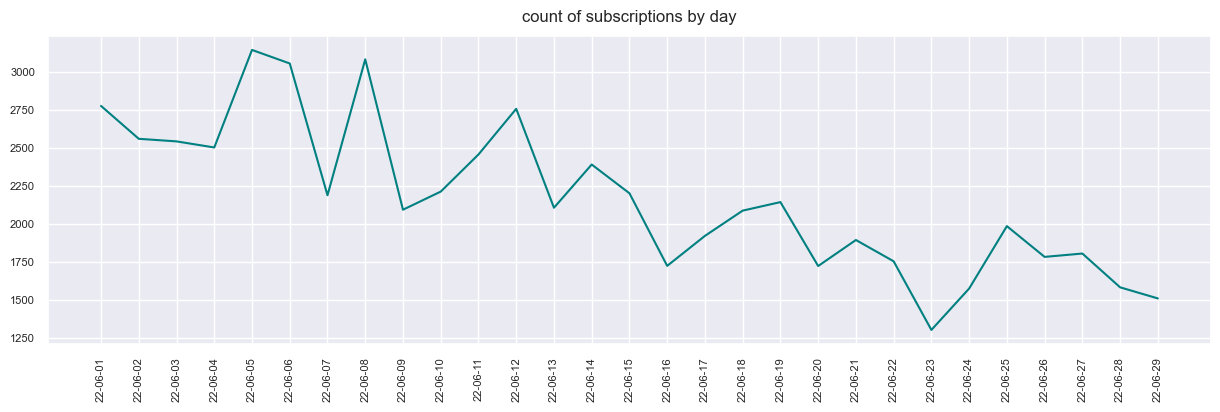

In [33]:
df_subs['subscription_date'] = df_subs['subscription_date'].dt.strftime('%y-%m-%d')

sns.set_theme()
plt.figure(figsize = (15, 4))
aux = df_subs.groupby('subscription_date')['user_id'].count()
sns.lineplot(data = aux , color = 'teal')
set_chart_config('count of subscriptions by day', '', '')
plt.xticks(rotation = 90);

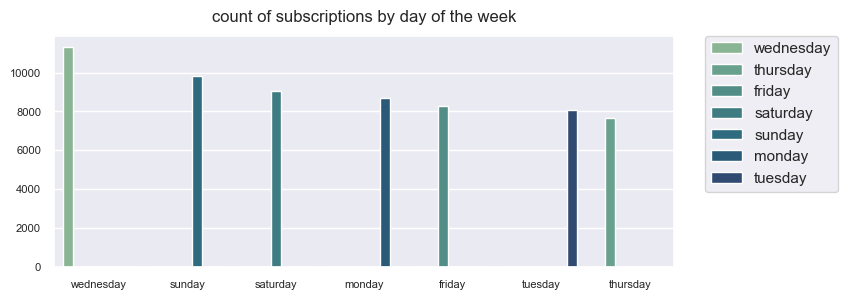

In [34]:
sns.set_theme()
plt.figure(figsize = (8, 3))

order = df_subs['day_of_week'].value_counts().to_frame().index
sns.countplot(data = df_subs, hue = 'day_of_week', x= 'day_of_week', order = order, palette = 'crest')
set_chart_config('count of subscriptions by day of the week', '', '')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);


***

1. Looking at the count of subscriptions per day, we clearly see a decrease.
2. There're two peaks, both at the beginning of June.
3. Wednesday is the day which more users have signed
4. Thursday, on the other hand, is the day with fewer users subscribing.
5. There's also a really small value on June 23rd - possible an issue

***

###  UNSUBSCRIPTION DATE

In [35]:
# have unsubscripted
df_unsub = df_subs[~df_subs['unsubscription_date'].isna()]

In [36]:
#removing the hour, min and sec from our datetime columns
df_unsub = df_unsub.copy(deep = True)
df_unsub['subscription_date'] = pd.to_datetime(df_unsub['subscription_date'], format='%y-%m-%d')

df_unsub['unsubscription_date'] = df_unsub['unsubscription_date'].dt.strftime('%y-%m-%d')
df_unsub['unsubscription_date'] = pd.to_datetime(df_unsub['unsubscription_date'], format='%y-%m-%d')

In [37]:
# creating columns = days from subs to unsub
df_unsub['days_to_unsub'] = df_unsub['unsubscription_date'] - df_unsub['subscription_date']

In [38]:
df_unsub = df_unsub[['user_id', 'subscription_date', 'unsubscription_date', 'days_to_unsub']]

In [39]:
# removing duplicates
df_unsub = df_unsub.drop_duplicates()

# changing timedelta64[ns] type to float
df_unsub['days_to_unsub'] = df_unsub['days_to_unsub'].astype('timedelta64[D]')

In [40]:
df_unsub['days_to_unsub'].value_counts(normalize = True).to_frame()

,days_to_unsub
0.0,0.643207
14.0,0.133689
7.0,0.038217
1.0,0.027978
21.0,0.025671
35.0,0.018027
15.0,0.011393
28.0,0.010239
2.0,0.008797
8.0,0.005336


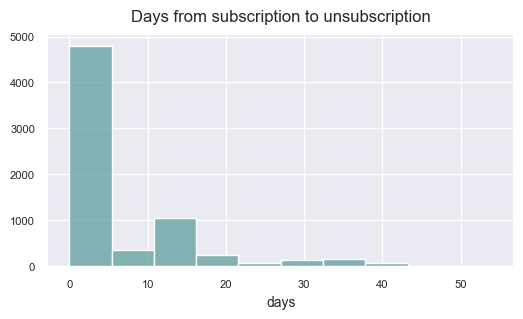

In [41]:
sns.set_theme()
plt.figure(figsize = (6, 3))

sns.histplot(data = df_unsub, x ='days_to_unsub', bins = 10, color = 'cadetblue')
sns.despine(bottom = True, left = True)

set_chart_config('Days from subscription to unsubscription',
                'days',
                '')

In [42]:
mean_t = df_unsub['days_to_unsub'].mean()
median_t = df_unsub['days_to_unsub'].median()
mode_t = df_unsub['days_to_unsub'].mode()

print(f'Mean    {mean_t},\nMedian: {median_t}\nMode: {mode_t}')

Mean    5.608451110470147,
Median: 0.0
Mode: 0    0.0
Name: days_to_unsub, dtype: float64


***

1. 64% of the users unsubscribe on the same day. 
2. 13% of the users unsubscribe after 14 days
3. The following days represent a small percentage of the data ( < 3%)
4. The median (0) also represents the high percentage of users unsubscribing right after subscribing.

***

### STATUS

#### PROPORTION OF DELIVERED x FAILED

In [43]:
# removing pending (we don't know which status is going to be)
df_status = df[df['status'] != 'Pending']

In [44]:
df_status['status'].value_counts(normalize = True)

Failed       0.720064
Delivered    0.279936
Name: status, dtype: float64

In [45]:
delivered = df_status[df_status['status'] == 'Delivered'].groupby('user_id').count()[['status']].rename(columns=({'status' : 'delivered'}))
failed = df_status[df_status['status'] == 'Failed'].groupby('user_id').count()[['status']].rename(columns=({'status' : 'failed'}))

In [46]:
df_status_user = delivered.merge(failed, on = 'user_id')

df_status_user['proportion'] = round(df_status_user['failed'] / df_status_user['delivered'], 1)
df_status_user.head()

,delivered,failed,proportion
user_id,,,
00174340ea5f11ecab61e5053e64927e,2,5,2.5
002f0e30f6da11ec98339db181f14dac,3,1,0.3
00307ca0f7bd11ec867b553062cb5bf9,3,2,0.7
006f74e0e44a11ecaa7033b4a0ee0e67,5,3,0.6
0095eba0f7b111ecac15635d0d5eef51,1,4,4.0


In [47]:
print(df_status_user['proportion'].mean())
print(df_status_user['proportion'].median())
print(df_status_user['proportion'].mode())

2.1343420126671355
1.0
0    0.2
Name: proportion, dtype: float64


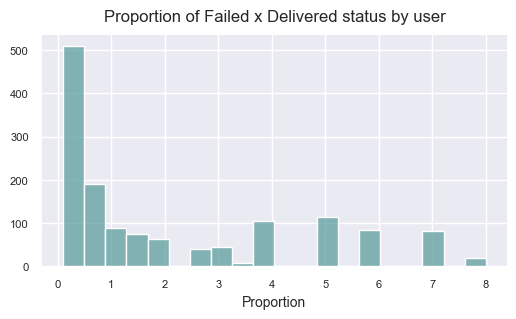

In [48]:
sns.set_theme()
plt.figure(figsize = (6, 3))

sns.histplot(data = df_status_user, x ='proportion', bins = 20, color = 'cadetblue')
sns.despine(bottom = True, left = True)

set_chart_config('Proportion of Failed x Delivered status by user',
                'Proportion',
                '')

***

The proportion of failed x delivered status is good:
    
    - Mean: 2.13
    - Median: 1

The histogram chart shows that most of the data is concentrated between 0 and 1, which means that the company needs less than one attempt to successfully charge the user. The following table exemplifies this metric.

- First user: For 1 failed attempt, there're 3 successful

- Second user: for 2 failed attempts, there are 3 succesfully

- Third user: for 3 failed attempts, there're 5 successfully

| user_id | delivered| 	failed	| proportion |
|-----    | -----    | -------  | ---------- |			
|002f0e30f6da11ec98339db181f14dac|	3|	1|	0.3|
|00307ca0f7bd11ec867b553062cb5bf9|	3|	2|	0.7|
|006f74e0e44a11ecaa7033b4a0ee0e67|	5|	3|	0.6|

***

#### BY STATUS, AFFILIATE AND SERVICE

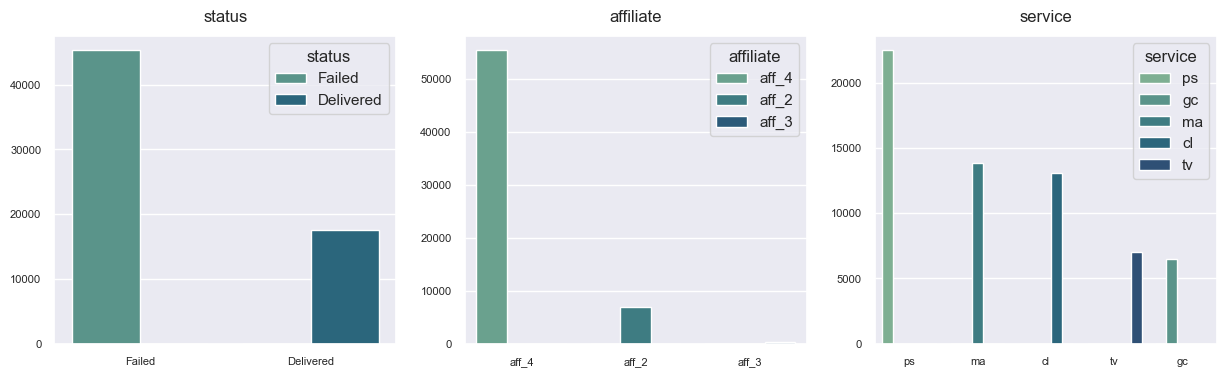

In [49]:
sns.set_theme()
plt.figure(figsize = (15, 4))

plt.subplot(1, 3, 1)
sns.countplot(data = df_status, hue = 'status', x= 'status', palette = 'crest')
set_chart_config('status', '', '')

plt.subplot(1, 3, 2)
sns.countplot(data = df_status, hue = 'affiliate', x= 'affiliate', palette = 'crest')
set_chart_config('affiliate', '', '')

plt.subplot(1, 3, 3)
order = df_status['service'].value_counts().to_frame().index
sns.countplot(data = df_status, hue = 'service', x= 'service', order = order, palette = 'crest')
set_chart_config('service', '', '')

***

1. 72% of the transactions are "Failed".
2. Affiliate aff_4 concentrates the majority of the data whereas affiliate aff_3 has quite a few
3. PS service is the most common one. The less common service is the GC

***

# DELIVERED TRANSACTIONS

***

In this section, we're going to analyze all delivered transactions. By doing so, will be possible to set a pattern for users who have had successful transactions.

As we've said before, the main goal is to define what variables impact most in successful and not successful billings attempts.

***

In [50]:
# creating dataframe
delivered = df.copy(deep = True)
delivered = delivered[delivered['status'] == 'Delivered']

## RFM TABLE

We're going to create a RFM table.

RMF stands for Recency, Frequency and Monetary value. These metrics have proven to be really effectivate predictor's to measure engagement and retention of customers.

**Recency**: How recently did the customer purchase from your company

**Frequency**: How often do your customers purchase in your store or visite your website

**Monetay**: How much do your customers spend in each visit ou purchase.

In [51]:
rfm = create_rfm_table(delivered)
rfm.head()

,recency,frequency,pricepoint_sum
user_id,,,
00067a80f50c11ec98339db181f14dac,96,5,18.0
00174340ea5f11ecab61e5053e64927e,131,2,7.2
002f0e30f6da11ec98339db181f14dac,101,3,10.8
00307ca0f7bd11ec867b553062cb5bf9,93,3,10.8
003a6770e74511ecbc89495b27b9c9c5,93,8,28.8


In [52]:
rfm['recency'].describe()

count    7567.000000
mean      123.935642
std        16.123604
min        93.000000
25%       112.000000
50%       127.000000
75%       137.000000
max       149.000000
Name: recency, dtype: float64

In [53]:
rfm['frequency'].describe()

count    7567.000000
mean        2.326021
std         1.876743
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        13.000000
Name: frequency, dtype: float64

In [54]:
rfm['pricepoint_sum'].describe()

count    7567.000000
mean        8.373675
std         6.756276
min         3.600000
25%         3.600000
50%         3.600000
75%        10.800000
max        46.800000
Name: pricepoint_sum, dtype: float64

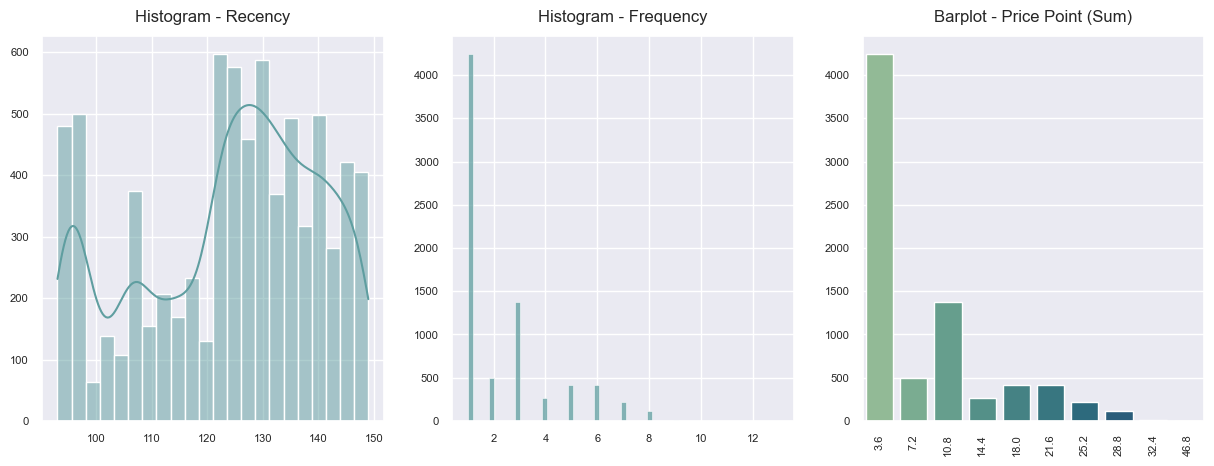

In [55]:
create_viz_rfm(delivered)

***

1. **Recency**
The recency data seems to be a bimodal distribution. There're two clear peaks - around 30 days and roughly greater than 60. The second one concentrates on the majority of the users, which means most of them have been charged 2 months ago.


2. **Frequency**
The frequency metric shows how many unique user has been charged. We can see that most of them are billed at one unique time. The second major group is the users with 3 successful billings attempts.


3. **Price Point**
The price point sums up the amount billed for each user. Since the majority have a frequency equal to 1, consequently, the biggest price bar will be the first one.
***


### CATEGORICAL ANALYSIS

Knowing our target variable (which is the Price Point), in this section, we're going to investigate how it is correlated to the categorical variables we've found important in the previous sections

In [56]:
create_days_of_week(delivered, 'transaction_timestamp')

# merging the rfm table
delivered = delivered.merge(rfm, how = 'inner', left_on = 'user_id', right_index = True)

In [57]:
#only categorical variables
cat_attributes = delivered.select_dtypes(exclude=['int64', 'float64'])

# adding pricepoint_sum - our target variable
cat_attributes = cat_attributes.merge(delivered[['pricepoint_sum', 'user_id']], how = 'left', on = 'user_id')

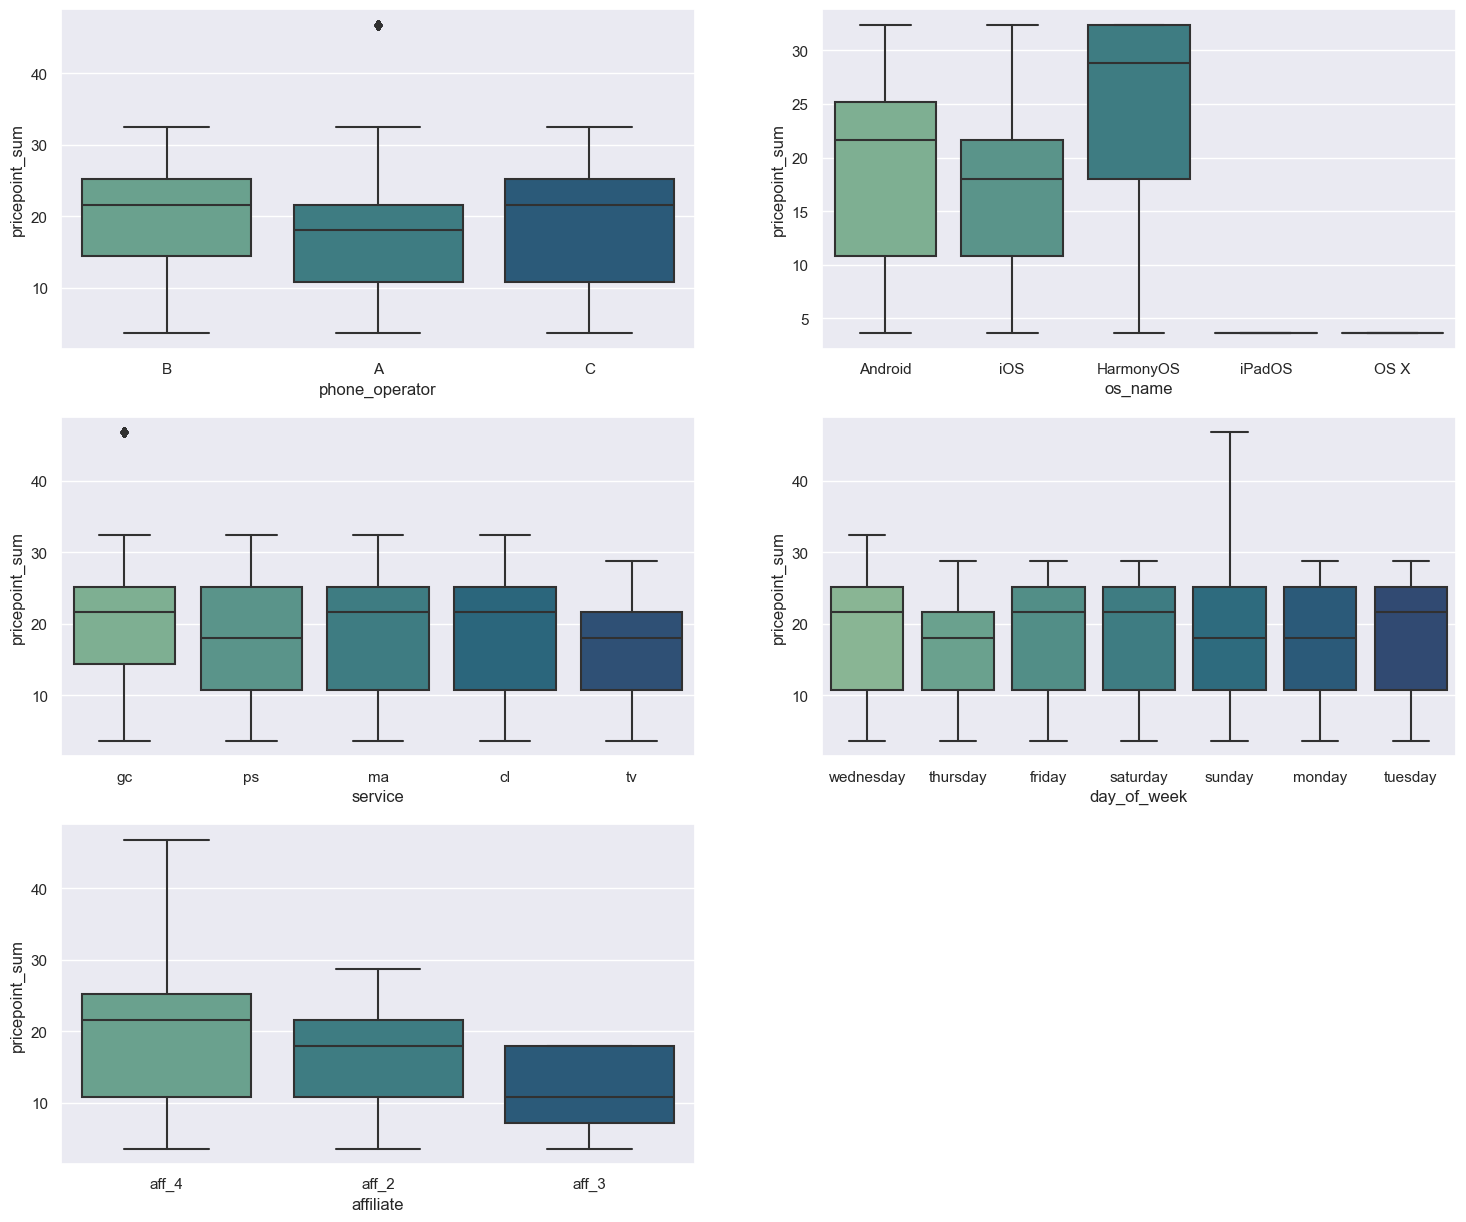

In [58]:
# target columns
cols = ['phone_operator', 'os_name', 'service', 'day_of_week', 'affiliate']

# data visualization
plt.figure(figsize=(18, 15))
x = 1

for i in cat_attributes[cols]:
    plt.subplot(3, 2, x)
    sns.boxplot(data = cat_attributes, x = i, y = 'pricepoint_sum', palette = 'crest')
    x += 1


***

1. **Phone operator**
The phone operator B seems the most profitable one, followed by operators C and A. In the general data, operator B is the most common one, but its median is the lowest one as well.


2. **OS name**
Harmony is an outlier as we've seen at the beginning of the analysis, so, we're not going to consider it. The same for iPad and OSx. Between Android and IOS, Android users are more likely to have a successful charge. Its mean and median are greater than iOS


3. **Service**
Most of the services look pretty similar. The TV is an exception as well as the median of PS. GC product seems to be the best one regarding profit.


4. **Day of Week**
In the previous section, in all data, we've seen that Wednesday is the most common day for new subscriptions. It median also looks slightly higher than the other days. Sunday has the greatest superior limit. 


5. **Affiliate**
There's a huge difference among the affiliates. aff_4 is by far the most profitable one. Something interesting is that aff_3 has way fewer subscriptions (in general data) and regarding profit, is also the last one.

***



### OVERALL SCORE

According to the previous analysis, where we investigated the more common variables, the ones with more discrepancies, etc., based on all we've done and the business knowledge, we're going to attribute a score for each value.

This way will be possible to create an overall score, regardless of the variable type. Also, will be possible to standardize the whole dataset.

In [59]:
# removing columns and duplicates
delivered = delivered[['user_id', 'phone_operator', 'os_name', 'affiliate', 
        'service', 'day_of_week', 'recency', 'frequency', 'pricepoint_sum']]

delivered = delivered.drop_duplicates()

#removing NA
delivered = delivered.dropna()

delivered = delivered.set_index('user_id')

In [60]:
dictionaries = {
    'A' : 1,
    'B' : 3,
    'C' : 2,
    
    'Android'   : 2,
    'iOS'       : 1,
    'HarmonyOS' : 0,
    'iPadOS'    : 0,
    'OS X'      : 0,
    
    'gc' : 3,
    'cl' : 2,
    'ma' : 2,
    'ps' : 2,
    'tv' : 1,
    
    'monday'    : 2,
    'tuesday'   : 2,
    'wednesday' : 3,
    'thursday'  : 1,
    'friday'    : 2,
    'saturday'  : 3,
    'sunday'    : 2,

    'aff_3' : 1,
    'aff_2' : 2,
    'aff_4' : 3
}
    

In [61]:
delivered.head()

,phone_operator,os_name,affiliate,service,day_of_week,recency,frequency,pricepoint_sum
user_id,,,,,,,,
4058b340e19e11ec95703f2faa3b39a3,B,Android,aff_4,gc,wednesday,135,1,3.6
91299d70e1d511ec8a541fcc86ad2588,B,iOS,aff_4,ps,wednesday,135,3,10.8
2414d890e25b11ecae2c8b58f62b8645,B,Android,aff_4,ps,thursday,127,4,14.4
4ba3b470e27a11eca8957b6cb3999042,B,Android,aff_4,ma,thursday,148,1,3.6
c08bcf60e31111eca8957b6cb3999042,B,Android,aff_4,cl,friday,147,1,3.6


In [62]:
cols = ['phone_operator', 'service', 'day_of_week', 'affiliate', 'os_name']
for i in delivered[cols]:
    delivered[i] = delivered[i].map(dictionaries)

In [63]:
#creating a score for recency
change_recency_score(delivered)

# sum all columns - total score
delivered['total_score'] = delivered.sum(axis=1)
delivered['total_score'] = abs(delivered['total_score'])
delivered.head()

,phone_operator,os_name,affiliate,service,day_of_week,recency,frequency,pricepoint_sum,total_score
user_id,,,,,,,,,
4058b340e19e11ec95703f2faa3b39a3,3,2,3,3,3,1,1,3.6,19.6
91299d70e1d511ec8a541fcc86ad2588,3,1,3,2,3,1,3,10.8,26.8
2414d890e25b11ecae2c8b58f62b8645,3,2,3,2,1,1,4,14.4,30.4
4ba3b470e27a11eca8957b6cb3999042,3,2,3,2,1,1,1,3.6,16.6
c08bcf60e31111eca8957b6cb3999042,3,2,3,2,2,1,1,3.6,17.6


# FAILED TRANSACTIONS

We've investigated all delivered transactions, so in this section, we'll analyze the failed transactions.

Based on the variables we do know that impact the main target and having transformed them from nominal to ordinal, we have a standard score, regardless of the type of the variable.

## RFM TABLE

In [64]:
failed = df.copy(deep = True)
failed = failed[failed['status'] == 'Failed']

In [65]:
rfm = create_rfm_table(failed)

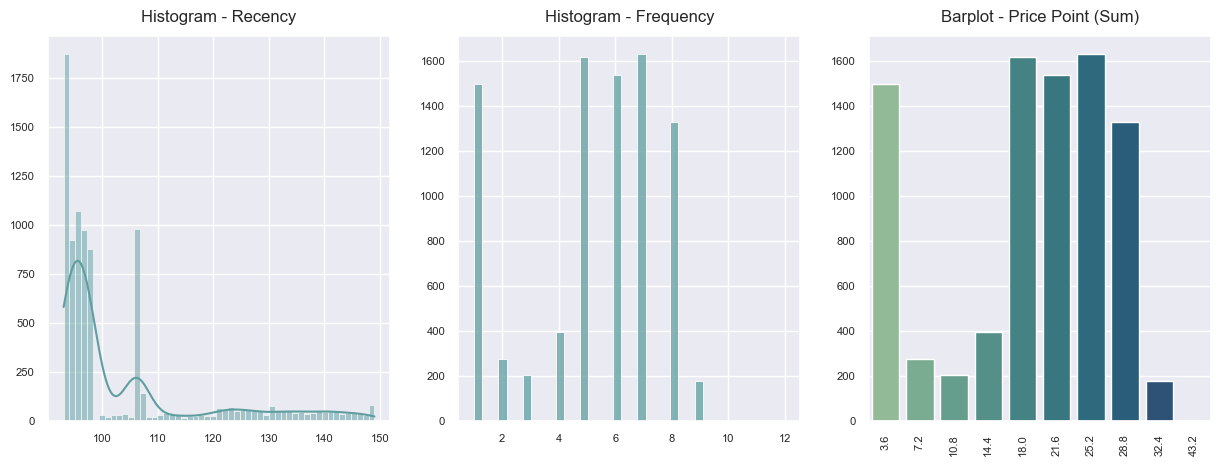

In [66]:
create_viz_rfm(failed)

### OVERALL SCORE

In [67]:
create_days_of_week(failed, 'transaction_timestamp')

# merging the rfm table
failed = failed.merge(rfm, how = 'inner', left_on = 'user_id', right_index = True)

In [68]:
failed = failed[['user_id', 'phone_operator', 'os_name', 'affiliate', 'service', 
                 'day_of_week', 'recency', 'frequency', 'pricepoint_sum']]

failed = failed.drop_duplicates()

failed = failed.dropna()

failed = failed.set_index('user_id')

In [69]:

# failed['phone_operator'] = failed['phone_operator'].map(phone_operator)
# failed['service'] = failed['service'].map(service)
# failed['day_of_week'] = failed['day_of_week'].map(day_of_week)
# failed['affiliate'] = failed['affiliate'].map(affiliate)
# failed['os_name'] = failed['os_name'].map(os_name)

cols = ['phone_operator', 'service', 'day_of_week', 'affiliate', 'os_name']
for i in failed[cols]:
    failed[i] = failed[i].map(dictionaries)

In [70]:
change_recency_score(failed)

,phone_operator,os_name,affiliate,service,day_of_week,recency,frequency,pricepoint_sum
user_id,,,,,,,,
4058b340e19e11ec95703f2faa3b39a3,3,2.0,3,3,3,1,8,28.8
a0b80170e1b011ec8a541fcc86ad2588,2,2.0,3,2,3,1,9,32.4
ee930990e1fa11ecb2988337303a8fef,2,2.0,3,2,3,1,7,25.2
ee930990e1fa11ecb2988337303a8fef,2,2.0,3,2,1,1,7,25.2
86fa07f0e26511ecb4346f30d03a03b3,2,2.0,3,2,1,1,7,25.2
...,...,...,...,...,...,...,...,...
bbdfbc80f79611eca4a103a479708082,1,2.0,3,2,3,1,1,3.6
74ecbe20f7bb11eca4a103a479708082,2,2.0,3,2,3,1,1,3.6
93225370f7be11ec867b553062cb5bf9,3,1.0,3,2,3,1,5,18.0


In [71]:
# once we're working with failed billings attempts, there's no sense in sum these variables
# i.e frequency for failed attemps means that as this number is higher, worst it is
# that's why we're changing them to negative

#failed['recency'] = failed['recency'] * -1
failed['frequency'] = failed['frequency']  *-1
failed['pricepoint_sum'] = failed['pricepoint_sum'] *-1

# sum all columns - total score
failed['total_score'] = failed.sum(axis=1)
failed['total_score'] = abs(failed['total_score'])
failed.head()

,phone_operator,os_name,affiliate,service,day_of_week,recency,frequency,pricepoint_sum,total_score
user_id,,,,,,,,,
4058b340e19e11ec95703f2faa3b39a3,3,2.0,3,3,3,1,-8,-28.8,21.8
a0b80170e1b011ec8a541fcc86ad2588,2,2.0,3,2,3,1,-9,-32.4,28.4
ee930990e1fa11ecb2988337303a8fef,2,2.0,3,2,3,1,-7,-25.2,19.2
ee930990e1fa11ecb2988337303a8fef,2,2.0,3,2,1,1,-7,-25.2,21.2
86fa07f0e26511ecb4346f30d03a03b3,2,2.0,3,2,1,1,-7,-25.2,21.2


## K-MEANS

For this step, we're going to use K-Means, an unsupervised machine learning algorithm.

Knowing all the scores, important variables, frequency, recency, the sum of price points per user, etc., we're going to separate our data into 3 clusters. This way will be possible to understand, by the distance of each data point, how our users are grouped and then, we can move forward to plan action.

## ELBOW METHOD

The elbow method is used to determine the optimal number of clusters in k-means clustering.

Note: Although it's a very useful and common method, is up to the business decision the optimal number of clusters

In [72]:
scaler = StandardScaler()
failed = failed.dropna()

X = failed
x_std = scaler.fit_transform(X)

x_std

array([[ 1.22357826,  0.55174041,  0.36806961, ..., -1.14809182,
        -1.14809182,  0.97425169],
       [-0.0598387 ,  0.55174041,  0.36806961, ..., -1.56772448,
        -1.56772448,  1.90659002],
       [-0.0598387 ,  0.55174041,  0.36806961, ..., -0.72845917,
        -0.72845917,  0.60696689],
       ...,
       [ 1.22357826, -1.78780795,  0.36806961, ...,  0.11080614,
         0.11080614, -0.69265625],
       [-0.0598387 ,  0.55174041,  0.36806961, ...,  0.11080614,
         0.11080614, -0.69265625],
       [-0.0598387 ,  0.55174041,  0.36806961, ...,  0.11080614,
         0.11080614, -0.83391964]])

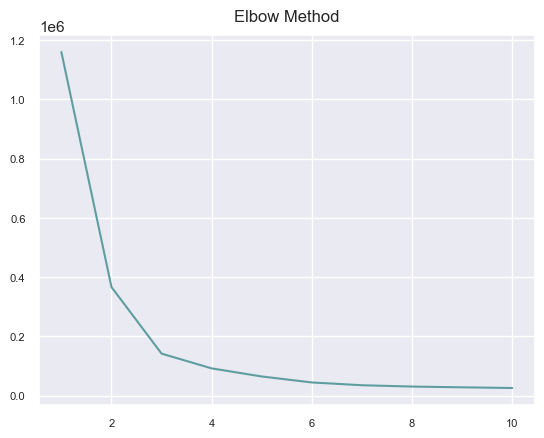

In [73]:
sns.set_theme()

wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init= 'k-means++', random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss, color = 'cadetblue')
set_chart_config('Elbow Method', '', '')

In [74]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)

kmeans.fit(x_std)
failed['cluster'] = kmeans.predict(x_std)

centroids = kmeans.cluster_centers_

/var/folders/hv/c3cdg1md2nn79bvtm31b_k840000gp/T/ipykernel_6115/3664028641.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failed['cluster'] = kmeans.predict(x_std)


## CLUSTERS VISUALIZATION

In [75]:
failed = failed.copy(deep = True)

failed['pricepoint_sum_jitter'] = random.randint(-4, 5, len(failed)) + failed['pricepoint_sum']
failed['total_score_jitter'] = random.randint(-4, 5, len(failed)) + failed['total_score']

/var/folders/hv/c3cdg1md2nn79bvtm31b_k840000gp/T/ipykernel_6115/2579879439.py:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax3 = sns.barplot(data = failed, x = 'cluster', y = 'total_score',  estimator=mean,  order = order,


<Figure size 640x480 with 0 Axes>

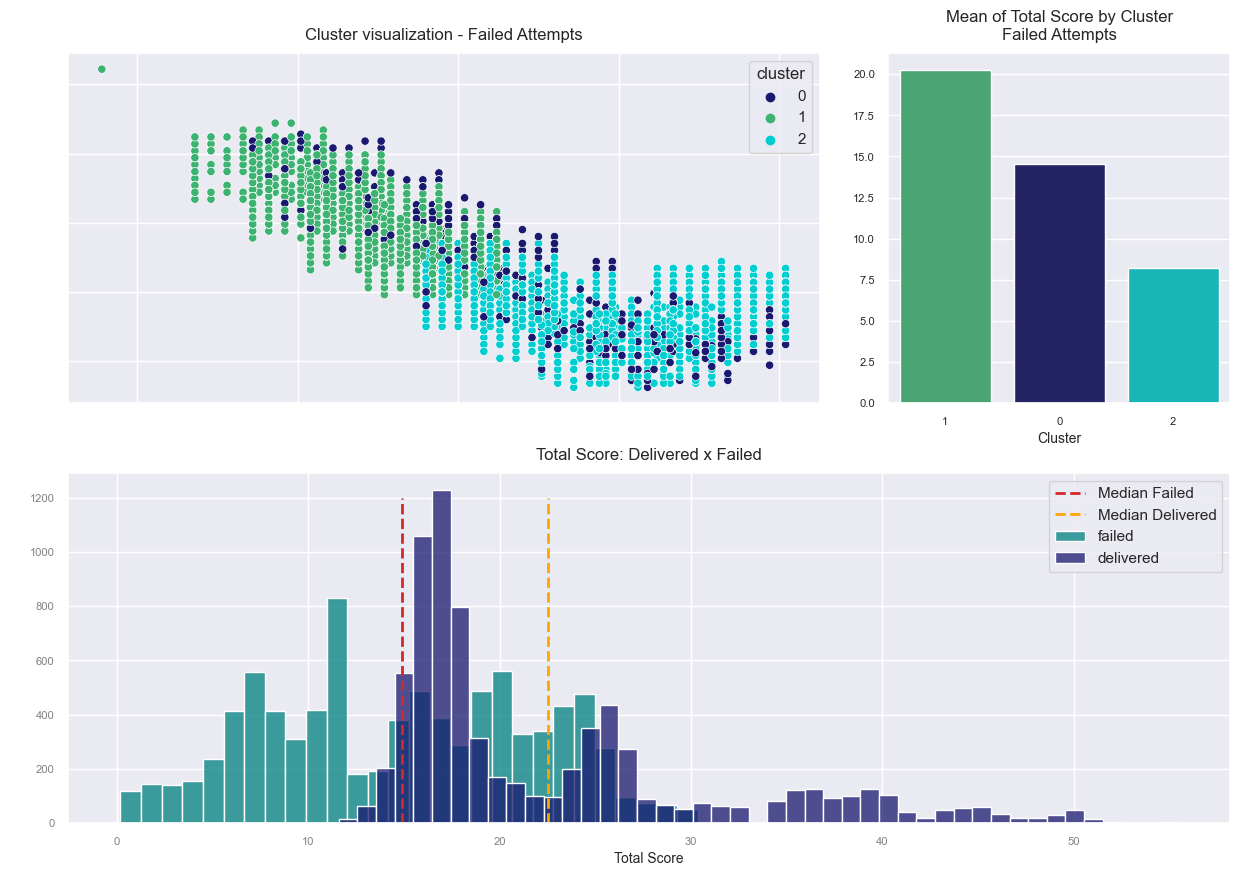

In [76]:
m1 = failed['total_score'].mean()
m2 = delivered['total_score'].mean()

fig3 = plt.figure(constrained_layout=True);
fig3 = plt.figure(figsize=(15,10));

gs = fig3.add_gridspec(2, 3) ## number of charts
fig3.add_subplot(gs[1, :]) ##chart 1

ax1 =sns.histplot(data = failed['total_score'], color = 'teal', label = 'failed')
med1 = plt.vlines(x=m1, linewidth=2, color='#d62728', ymin=0, ymax=1200, linestyle='--', 
                label = 'Median Failed')
ax = sns.histplot(data = delivered['total_score'], color = 'midnightblue', label = 'delivered')
med2 = plt.vlines(x=m2, linewidth=2, color='orange', ymin=0, ymax=1200, linestyle='--', 
                label = 'Median Delivered')

set_chart_config('Total Score: Delivered x Failed', 'Total Score', ' ')
plt.xticks(color = 'grey', fontsize = 8);
plt.yticks(color = 'grey', fontsize = 8);
plt.legend();

fig3.add_subplot(gs[0, :-1])
ax1 = sns.scatterplot(data = failed, x='pricepoint_sum_jitter', y = 'total_score_jitter', hue = 'cluster',
                    palette = {0 : 'midnightblue', 1 : 'mediumseagreen', 2 : 'darkturquoise'})
                   
set_chart_config('Cluster visualization - Failed Attempts', '', '')
plt.xticks(color = 'white');
plt.yticks(color = 'white');

fig3.add_subplot(gs[0, 2])
order = failed.groupby('cluster')['total_score'].mean().sort_values(ascending = False).index
ax3 = sns.barplot(data = failed, x = 'cluster', y = 'total_score',  estimator=mean,  order = order,
                 palette = {0 : 'midnightblue', 1 : 'mediumseagreen', 2 : 'darkturquoise'}, ci= False)

set_chart_config('Mean of Total Score by Cluster\nFailed Attempts', 'Cluster', '');

***

1. For the first chart, we have a scatterplot with 3 groups generated using K-means algorithm. By having this visualization (handing the dataset with the customer ID as well), it's possible to address the best business decisions.


2. In The second chart there's a barplot comparing the mean of the total score for each cluster. As an initial analysis, we can have a big picture of the most, middle, and less important clusters based on the total score we've set before. Using the CRISP-DM methodology, we can dig into each cluster and have more information.


3. In the third chart, the histogram plot, we can compare the Total Score between the users who have had the delivered billing and the ones that haven't (failed). These two charts show how these two groups are different from each other, in number of users and also the total score. The goal is to maximize the delivered chart and consequently, decrease the failed one.


## FINAL DATAFRAME

***

Exporting the final dataframe of failed delivered, by user, with cluster number for each record.

In [77]:
#target columns
failed_export = failed[['phone_operator', 'os_name', 'affiliate', 'service', 'day_of_week',
       'recency', 'frequency', 'pricepoint_sum', 'total_score', 'cluster']]

# transforming negative values
failed_export = failed_export.abs()

In [78]:
# changing back to categorical variables
failed_export['phone_operator'] = failed_export['phone_operator'].map(d.phone_operator)
failed_export['os_name'] = failed_export['os_name'].map(d.os_name)
failed_export['service'] = failed_export['service'].map(d.service)
failed_export['day_of_week'] = failed_export['day_of_week'].map(d.day_of_week)
failed_export['affiliate'] = failed_export['affiliate'].map(d.affiliate)

failed_export

,phone_operator,os_name,affiliate,service,day_of_week,recency,frequency,pricepoint_sum,total_score,cluster
user_id,,,,,,,,,,
4058b340e19e11ec95703f2faa3b39a3,NaN,Android,aff_4,gc,saturday,1,8,28.8,21.8,1
a0b80170e1b011ec8a541fcc86ad2588,C,Android,aff_4,ps,saturday,1,9,32.4,28.4,1
ee930990e1fa11ecb2988337303a8fef,C,Android,aff_4,ps,saturday,1,7,25.2,19.2,1
ee930990e1fa11ecb2988337303a8fef,C,Android,aff_4,ps,thursday,1,7,25.2,21.2,1
86fa07f0e26511ecb4346f30d03a03b3,C,Android,aff_4,ps,thursday,1,7,25.2,21.2,1
...,...,...,...,...,...,...,...,...,...,...
bbdfbc80f79611eca4a103a479708082,A,Android,aff_4,ps,saturday,1,1,3.6,7.4,2
74ecbe20f7bb11eca4a103a479708082,C,Android,aff_4,ps,saturday,1,1,3.6,8.4,2
93225370f7be11ec867b553062cb5bf9,NaN,iOS,aff_4,ps,saturday,1,5,18.0,10.0,2


In [93]:
import dash
import plotly
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go




In [100]:
# fig = px.scatter(x = failed['pricepoint_sum_jitter'], y = failed['total_score_jitter'], color=failed['cluster'])
# fig.update_coloraxes(showscale=False)

fig = make_subplots(rows=1, cols=2)

fig.add_trace(go.Scatter(x = failed['pricepoint_sum_jitter'], y = failed['total_score_jitter'], marker_color=failed['cluster'],
mode = 'markers'), row = 1, col = 2)


                                                                                            
fig.show()
#failed.head()

In [97]:
failed[['pricepoint_sum_jitter', 'total_score_jitter']]

,pricepoint_sum_jitter,total_score_jitter
user_id,,
4058b340e19e11ec95703f2faa3b39a3,-31.8,18.8
a0b80170e1b011ec8a541fcc86ad2588,-28.4,32.4
ee930990e1fa11ecb2988337303a8fef,-23.2,20.2
ee930990e1fa11ecb2988337303a8fef,-26.2,23.2
86fa07f0e26511ecb4346f30d03a03b3,-22.2,22.2
...,...,...
bbdfbc80f79611eca4a103a479708082,-1.6,7.4
74ecbe20f7bb11eca4a103a479708082,-6.6,7.4
93225370f7be11ec867b553062cb5bf9,-14.0,11.0
